## 10.6.1 CartPole
### Introduction
In this notebook, we implement a Deep Q-Network (DQN) to solve the CartPole-v1 environment from OpenAI's Gym. 

The CartPole problem is a classic reinforcement learning task where the goal is to balance a pole on a moving cart. The environment provides observations about the cart's position and velocity, as well as the pole's angle and angular velocity. The agent's objective is to apply forces to the cart in order to keep the pole upright for as long as possible.

The DQN algorithm combines Q-learning with deep neural networks to approximate the Q-values, which represent the expected future rewards for taking a given action in a given state. This approach allows the agent to handle large state spaces effectively and make decisions that maximize cumulative rewards over time.

In this implementation, we'll train a DQN agent using experience replay and target networks to stabilize learning. We will evaluate the agent's performance by tracking its rewards over episodes and plotting the results.

In [1]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Create the CartPole environment
env = gym.make('CartPole-v1')

In [4]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [5]:
# Neural network model for approximating Q-values
def create_q_model():
    model = tf.keras.Sequential([
        layers.Input(shape=(4,), dtype=tf.float32),
        layers.Dense(24, activation='relu'),
        layers.Dense(24, activation='relu'),
        layers.Dense(env.action_space.n, activation='linear')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
    return model

In [6]:
# Hyperparameters
gamma = 0.99       # Discount factor
epsilon = 1.0      # Exploration rate
epsilon_min = 0.1  # Minimum exploration rate
epsilon_decay = 0.995  # Decay rate for exploration
batch_size = 32    # Batch size for training
train_start = 1000 # Start training after this many steps
memory_max = 2000  # Maximum memory size

In [7]:
# Initialize memory, model, and optimizer
memory = []
model = create_q_model()
target_model = create_q_model()
target_model.set_weights(model.get_weights())

In [8]:
# Function to choose an action based on epsilon-greedy policy
def choose_action(state, epsilon):
    if np.random.rand() <= epsilon:
        return np.random.choice(env.action_space.n)
    q_values = model.predict(np.expand_dims(state, axis=0), verbose=0)
    return np.argmax(q_values[0])


In [9]:
# Function to replay and train the model
def replay():
    if len(memory) < train_start:
        return

    # Sample a minibatch from memory
    minibatch = np.random.choice(len(memory), batch_size, replace=False)

    # Prepare state, next_state batches
    state_batch = np.array([memory[i][0] for i in minibatch], dtype=np.float32)
    next_state_batch = np.array([memory[i][3] for i in minibatch], dtype=np.float32)

    # Predict Q-values for current and next states
    q_values_batch = model.predict(state_batch, verbose=0)
    q_values_next = target_model.predict(next_state_batch, verbose=0)

    for i, index in enumerate(minibatch):
        state, action, reward, next_state, done = memory[index]

        # Update Q-value using the Bellman equation
        target = reward
        if not done:
            target += gamma * np.amax(q_values_next[i])
        q_values_batch[i][action] = target

    # Train the model on the entire batch
    model.fit(state_batch, q_values_batch, epochs=1, verbose=0)


In [10]:
# Main training loop
episodes = 400
rewards = []

for episode in range(episodes):
    state = env.reset()
    state = np.array(state, dtype=np.float32)
    episode_reward = 0

    while True:
        action = choose_action(state, epsilon)
        next_state, reward, done, _ = env.step(action)
        next_state = np.array(next_state, dtype=np.float32)

        # Store the experience in memory
        memory.append((state, action, reward, next_state, done))
        if len(memory) > memory_max:
            memory.pop(0)

        state = next_state
        episode_reward += reward

        if done:
            rewards.append(episode_reward)
            break

        replay()

    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

    # Update the target model weights
    if episode % 10 == 0:
        target_model.set_weights(model.get_weights())

    # Print progress
    if episode % 20 == 0:
        print(f"Episode: {episode}, Reward: {episode_reward}, Epsilon: {epsilon:.4f}")

Episode: 0, Reward: 20.0, Epsilon: 0.9950
Episode: 20, Reward: 35.0, Epsilon: 0.9001
Episode: 40, Reward: 14.0, Epsilon: 0.8142
Episode: 60, Reward: 10.0, Epsilon: 0.7366
Episode: 80, Reward: 23.0, Epsilon: 0.6663
Episode: 100, Reward: 38.0, Epsilon: 0.6027
Episode: 120, Reward: 84.0, Epsilon: 0.5452
Episode: 140, Reward: 92.0, Epsilon: 0.4932
Episode: 160, Reward: 126.0, Epsilon: 0.4462
Episode: 180, Reward: 128.0, Epsilon: 0.4036
Episode: 200, Reward: 146.0, Epsilon: 0.3651
Episode: 220, Reward: 192.0, Epsilon: 0.3303
Episode: 240, Reward: 115.0, Epsilon: 0.2988
Episode: 260, Reward: 25.0, Epsilon: 0.2703
Episode: 280, Reward: 222.0, Epsilon: 0.2445
Episode: 300, Reward: 144.0, Epsilon: 0.2212
Episode: 320, Reward: 142.0, Epsilon: 0.2001
Episode: 340, Reward: 135.0, Epsilon: 0.1810
Episode: 360, Reward: 137.0, Epsilon: 0.1637
Episode: 380, Reward: 162.0, Epsilon: 0.1481


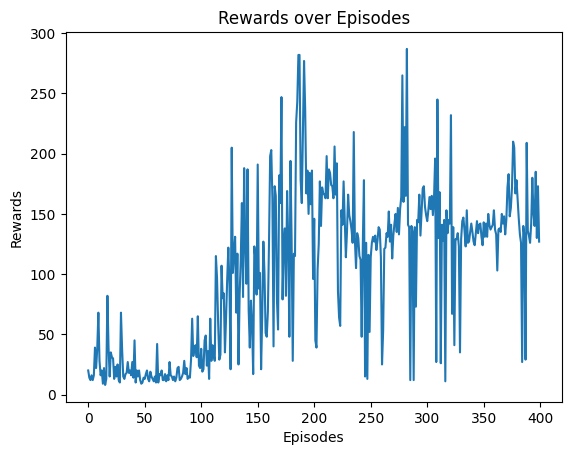

In [11]:
# Plot the rewards over episodes
plt.plot(rewards)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('Rewards over Episodes')
plt.show()

env.close()


### Conclusion
The **DQN** implementation for the CartPole-v1 environment effectively demonstrates how reinforcement learning can be applied to a classic control problem. By using a **neural network to approximate Q-values** and incorporating techniques like experience replay and target networks, the agent learns to balance the pole on the cart through trial and error.

The training process involves repeatedly interacting with the environment, updating the Q-values based on the observed rewards, and refining the policy to improve performance. As evidenced by the reward plot, the agent's performance typically improves over episodes, indicating successful learning.

This implementation highlights the power of combining reinforcement learning with deep learning techniques, showcasing the ability to handle complex problems with high-dimensional state spaces. Future enhancements could include experimenting with different network architectures, hyperparameters, or advanced techniques like Double DQN or Prioritized Experience Replay to further improve the agent's performance.